# Inspection of DC2 Run 2.2i DR6 Object Table with Dask
### Michael Wood-Vasey (@wmwv)
### Last Verified to Run: 2021-05-26 by MWV

Inspect the Run 2.2i DR6 Object Table  
Using a Dask Cluster on one NERSC node as the backend.

#### Run 2.2i DR6
  * 166 tracts
  * 147 million objects  

Logistics:

1. These tests were conducted on NERSC through the https://jupyter.nersc.gov interface.  
Note: To enable re-rastering when zooming, use the JupyterLab Classic interface.
You can launch this from an active JupyterHub Notebook by selecting "Help->Launch Classic Notebook".
  * You can select the "Running" tab and then select the Notebook you want.
  * You could instead browse through the full filesystem path under the "Files" tab to find your Notebook, but that's a lot more clicking.  You may want to take this aproach to launch some other Notebook that's not currently running under JupyterHub.

2. Requires:
```
dask
dask.distributed
holoviews
datashader
bokeh
pyarrow >= 0.13.1
```

and `graphviz` if you want to see the Dask task graphs.

Up-to-date versions of each of these are available in `desc-python-bleed` kernel

3. This was run using the `desc-python-bleed` kernel

We directly use the DPDD Parquet files.

4. We use Dask, HoloViews, and Datashader to read Parquet files.  For more on each of these, see:

References:  
    https://dask.org  
    https://datashader.org  
    https://parquet.apache.org  
    https://holoviews.org  
    https://holoviz.org
    
In brief:

### Parquet

Parquet is a column-based storage format that's part of a wider Arrow project to provide standardized, high-performance data representations in memory and on disk.  It's commonly used in current data science and large data volume processing, and is the current selected standard for Rubin Observatory LSST Data Management on-disk representations of output data catalogs.  The DESC Data Access Team is thus similarly using Parquet as the default underlying data format for representations of DC2 data as processed by the LSST DM Science Pipelines.

### Dask

Dask allows us to do processing by dividing tasks into individual workers.  These workers allow us to take fuller use of available memory and processors, including those on other machines.

Dask is solving the needs to:

1. Load more data than fit into memory. You can delay this in either time or space.
   * Delaying in time would be if you running on a memory-limited machine, then Dask will be able to chunk through the work units without simultaneously needing the full amount of memory to hold all of the data at once.
   * Delaying in space means spinning up additional machines.  This is often particularly powerful when connecting your front-end machine (e.g., a NERSC JupyterHub job is limited to 42 GB memory), to several full cluster compute nodes (e.g., a NERSC Haswell node is 32 real cores, 128 GB).  

2. Distributing work across multiple processors. Python and numpy/scipy are not naturally parallel or easily parallelizable. One of the common things we will do with large datasets is aggregate for both analysis and visualization. Being able to do this aggregation in parallel is a significant gain.


### HoloViews

HoloViews is Dask aware and can provide Dask the correct information to build a Task Graph that effectively parallelizes the requisite data loading and computation.  HoloViews can use either bokeh or matplotlib backends.  If you directly use the matplotlib backend with a Dask DataFrame it will not appropriately parallelize across the workers and instead do lots of stuff in serial.  Bokeh also gives some nice interactive capabilities and HoloViews knows how to appropriate set up the linking and call backs to enable coordinated zooming and selection.

## Approach.

Our limitation will be available memory and disk I/O.  There's a trade-off between them.  The more times we're willing to load from disk, the less we have to keep in memory.

1. Load enough data to get an index of `good` objects.
  a. 'good' column and 'magerr_{SNRfilter}' column.
  b. persist this index.
  b. Potentially also define `star` and `galaxy` indices.
2. Go through each sections exploring different columns of the database
  a. RA, Dec
  b. color, color
  c. number density of galaxies
  d. extendedness
  e. blendedness
  f. shape (moments)
  g. PSF

TODO
1. Plot colorbars for data-shaded plots
2. Control order of samples in Overlays.  Overlay currently alphabetizes in the legends.  I would like to learn how to force the order so the match the heights of the contributions, e.g. "good", "galaxy", "star".

## Import Needed Modules

In [1]:
import math
import os

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import astropy.units as u
import healpy as hp

In [2]:
import colorcet

import dask
from dask.distributed import Client

from bokeh.models import HoverTool
import dask.array as da
import dask.dataframe as dd
import datashader as ds
import holoviews as hv
from holoviews.operation import histogram
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews.plotting.util import process_cmap
from holoviews.streams import RangeXY

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
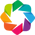

In [3]:
hv.extension('bokeh')

In [4]:
cmap = 'viridis'

If you set LOCAL_DASK to True, then select a more limited set of data, likely one Tract would be good.   
There's a 42 GB limit on memory directly in the JupyterHub environment, 
which you will hit pretty quickly if you try to read in all of the data

In [5]:
LOCAL_DASK = True
# LOCAL_DASK = False

## Start our Dask Cluster


For simple testing and illustration of how to use dask, holoview, and datashader here you can run locally on just one tract.
To run on the full set of DR6, you'll need to set up a a set of nodes to support Dask distributed.  Basically you just machine that can hold the data in memory on the reader.

### Start a local Dask Cluster

In [6]:
if LOCAL_DASK:
    client = Client()

### Start a Dask Cluster on an Interactive Nodes

So instead, in a separate Terminal on Cori, ask for a pair of Nodes from the `interactive` queue.  This generally completes in seconds.  We ask for 2 Nodes because we'd like the full ~256 GB of availablel memory to store the data and the intermediate copies that often get made in some of the plots below:

```
salloc -N 2 -C haswell --qos=interactive -t 04:00:00 -L SCRATCH
```

And then once on the first Node, where you'll get put after the `salloc` complets, load the right Python environment.  We also want to move to the $C
```
python /global/common/software/lsst/common/miniconda/start-kernel-cli.py desc-python-dev
```

And then start up the Dask Cluster
```
NUM_WORKERS=16
SCHEDULER_FILE=${CSCRATCH}/scheduler.json
rm -rf ${SCHEDULER_FILE}
dask-scheduler --scheduler-file ${SCHEDULER_FILE} &
dask-worker --nprocs ${NUM_WORKERS} --scheduler-file ${SCHEDULER_FILE} --local-directory /tmp &
```

Then exit the environment and go to the second Node.

```
python /global/common/software/lsst/common/miniconda/start-kernel-cli.py desc-python-dev
```

```
NUM_WORKERS=16
SCHEDULER_FILE=${CSCRATCH}/scheduler.json
dask-worker --nprocs ${NUM_WORKERS} --scheduler-file ${SCHEDULER_FILE} --local-directory /tmp &
```

The nodes will be printed out when the `salloc` launches.  And if you forget, you can look them up under the `SLURM_NODELIST` environment variable.

We used `CSCRATCH` above instead of `SCRATCH`, when specifying the location of the scheduler file, because `CSCRATCH` will be consistent across the nodes, whereas `SCRATCH` will be empty on the second compute node (the first one gets some special environment passing through because it's an interactive session).

We connect to this Dask cluster through a shared agreement on where the `SCHEDULER_FILE` is.

We then configure the dashboard URL to use the JupyterHub proxy service.
We here set the formatting string template to the correct value.
Once we actually connect the client, then client can then tell us the full link.

In [7]:
if not LOCAL_DASK:
    scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
    dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
    client = Client(scheduler_file=scheduler_file)

In [8]:
client

<Client: 'tcp://127.0.0.1:33624' processes=4 threads=8, memory=62.50 GiB>

In [9]:
# client.restart()

## Define Catalog and Subsampling

We specify the directory path that contains all of the individual Parquet files.  If we want to read just one tract, we could pass the full path name of just the tract.  If we wanted to specify a set of tracts to run, we could pass in a regex that matches those tracts.  Or we could pass in a list that contained the file paths or directory paths to read from.

In [9]:
# desc_data_dir = f"/global/cfs/cdirs/lsst/shared/DC2-prod/"
desc_data_dir = "/bgfs/mwood-vasey/wmwv"

In [10]:
data_release = "dr6"

run_data_dir = f"Run2.2i/dpdd/Run2.2i-{data_release}/object_dpdd_only"
data_path = os.path.join(desc_data_dir, run_data_dir)

In [11]:
print(data_path)

/bgfs/mwood-vasey/wmwv/Run2.2i/dpdd/Run2.2i-dr6/object_dpdd_only


In [12]:
# data_path_dr6c_tract3 = "/global/cfs/cdirs/lsst/shared/DC2-prod/Run2.2i/dpdd/Run2.2i-dr6c/dc2_object_run2.2i_dr6c/*tract3???.parquet"
# data_path = data_path_dr6c_tract3

In [13]:
# data_path = os.path.join("/global/cscratch1/sd/wmwv/DC2/Run2.2i/dc2_object_run2.2i_dr6d")

## Load Data

In [14]:
filters = ('u', 'g', 'r', 'i', 'z', 'y')

Parquet is a column-based storage format. If we specify the columns we want to load, then we avoid the memory overhead of having to store the other columns.
Note: In principle Dask should be able to figure out what columns we actually used and only used those.  But it doesn't really know what to keep around.

In [16]:
# Select good detections:
#  1. Marked as 'good' in catalog flags.
#  2. SNR in given band > threshold
#  3. In defined simulation range
snr_threshold = 5
snr_filter = 'i'

# We want to do a SNR cut, but magerr is the thing already calculated
# So we'll redefine our SNR in terms of magerr
magerr_cut = (2.5 / np.log(10)) / snr_threshold

In [15]:
# columns = ['objectId']
columns = ['objectId', f'magerr_{snr_filter}', 'good']

columns += ['ra', 'dec']
# columns += ['tract', 'patch']
columns += [f'mag_{f}' for f in filters]
columns += [f'magerr_{f}' for f in filters]
columns += [f'mag_{f}_cModel' for f in filters]
columns += [f'magerr_{f}_cModel' for f in filters]
columns += [f'I_flag']
columns += [f'I_flag_{f}' for f in filters]
columns += [f'Ixx_pixel_{f}' for f in filters]
columns += [f'Ixy_pixel_{f}' for f in filters]
columns += [f'Iyy_pixel_{f}' for f in filters]
columns += [f'psf_fwhm_{f}' for f in filters]
columns += ['good', 'extendedness', 'blendedness']

In [18]:
# df = dd.read_parquet(data_path, columns=columns, engine='pyarrow')
df = dd.read_parquet(data_path, columns=columns, engine='pyarrow', kwargs={'dataset': {'use_legacy_dataset': False}})

Calculating the size of the Dask DataFrame is relatively fast because Dask knows to just ask each of the Parquet files how many rows does it have.  It doesn't have to fully load it into memory.

In [19]:
len_df = len(df)

In [20]:
print(len_df)

147088478


In [21]:
# np.isfinite('blendedness')

good = df["good"] & (df[f"magerr_{snr_filter}"] < magerr_cut)
del df

### Visualize the Task Graph

We need `graphviz` to visualize the Task Graph.

In [ ]:
good.visualize()

In [23]:
# Define color columns
good['u-g'] = good['mag_u'] - good['mag_g']
good['g-r'] = good['mag_g'] - good['mag_r']
good['r-i'] = good['mag_r'] - good['mag_i']
good['i-z'] = good['mag_i'] - good['mag_z']
good['z-y'] = good['mag_z'] - good['mag_y']

In [24]:
good['galaxy'] = good['extendedness'] > 0

## Persist the data in Dask Cluster Worker memory

Dask actively purges data from memory when its no longer needed by the Dask Task Graph currently doing the computation.

But each plot below is its own separate computation.  Dask has no way of knowing that it's going to use those data again in the next plot.  We thus explicitly tell Dask to persist this data frame so that it's still already loaded when we plot the next thing.

If you don't have the physical memory across your Dask installation (whether local or remote), then skip this persist step.  Running each of the plots will require re-reading the data and bit a bit slower than if we had memory to keep all of the data, but will work fine.

So the following is the first command that will trigger an actual substantial data read of the Parquet file.  This should take about 10 seconds with 32 workers and 256 GB on NERSC.

In [ ]:
# good = good.persist()

### Define star/galaxy DataFrames

Define the star and galaxy DataFrame from good.  Now that `good` is persisted, future calls of `star` and `galaxy` shouldn't trigger new reads.  When I defined `star` and `galaxy` before persisting `good`, later references to `star` or `galaxy` would trigger re-reads of the data.

In [25]:
star = good[~good['galaxy']]
galaxy = good[good['galaxy']]

The following is expensive because we have to read in all of the length chunks to count up `df` again.

In [58]:
print(f'Total: {len_df}, Good: {len(good)}')

Total: 147088478, Good: 99621700


In [ ]:
print(f'Total: {len_df}, Good: {len(good)}, Stars: {len(star)}, Galaxies: {len(galaxy)}')

## Object Density in RA, Dec

DC2 Run 2.x WFD and DDF regions
https://docs.google.com/document/d/18nNVImxGioQ3tcLFMRr67G_jpOzCIOdar9bjqChueQg/view
https://github.com/LSSTDESC/DC2_visitList/blob/master/DC2visitGen/notebooks/DC2_Run2_regionCoords_WFD.ipynb

| Location          | RA (degrees) | Dec (degrees) | RA (degrees) | Dec (degrees) |
|:----------------- |:------------ |:------------- |:------------ |:------------- |
| Region            | WFD          | WFD           | DDF          | DDF           |
| Center            | 61.856114    | -35.79        | 53.125       | -28.100       |
| North-East Corner | 71.462228    | -27.25        | 53.764       | -27.533       |
| North-West Corner | 52.250000    | -27.25        | 52.486       | -27.533       |
| South-West Corner | 49.917517    | -44.33        | 52.479       | -28.667       |
| South-East Corner | 73.794710    | -44.33        | 53.771       | -28.667       |

(Note that the order of the rows above is different than in the DC2 papers.  The order of the rows above goes around the perimeter in order.)

In [59]:
dc2_run2x_wfd = [[71.462228, -27.25], [52.250000, -27.25], [49.917517, -44.33], [73.794710, -44.33]]
dc2_run2x_ddf = [[53.764, -27.533], [52.486, -27.533], [52.479, -28.667], [53.771, -28.667]]

In [60]:
dc2_run2x_wfd_df = pd.DataFrame({'ra': [coord[0] for coord in dc2_run2x_wfd] + [dc2_run2x_wfd[0][0]],
                                 'dec': [coord[1] for coord in dc2_run2x_wfd] + [dc2_run2x_wfd[0][1]]})
dc2_run2x_ddf_df = pd.DataFrame({'ra': [coord[0] for coord in dc2_run2x_ddf] + [dc2_run2x_ddf[0][0]],
                                 'dec': [coord[1] for coord in dc2_run2x_ddf] + [dc2_run2x_ddf[0][1]]})

In [61]:
def overlay_dc2_region(ra_dec, dc2_run2x_wfd_df=dc2_run2x_wfd_df, dc2_run2x_ddf_df=dc2_run2x_ddf_df):
    # This region isn't quite a polygon.  The sides should be curved.
    wfd_region = hv.Path(dc2_run2x_wfd_df).opts(color='red')
    ddf_region = hv.Path(dc2_run2x_ddf_df).opts(color='orange')
    ra_dec = ra_dec * wfd_region * ddf_region

    max_delta_ra = dc2_run2x_wfd_df['ra'][3] - dc2_run2x_wfd_df['ra'][2]
    delta_dec = dc2_run2x_wfd_df['dec'][1] - dc2_run2x_wfd_df['dec'][3]
    grow_buffer = 0.05

    # Notice that these are specified in increasing RA left->right
    # We rely on the invert_xaxis True above to flip this in the display
    # It's important to get this right because these ranges are used for data selection
    # and then the range is flipped in the display.
    ra_dec.opts(xlim=(dc2_run2x_wfd_df['ra'][2] - max_delta_ra * grow_buffer,
                dc2_run2x_wfd_df['ra'][3] + max_delta_ra * grow_buffer))
    ra_dec.opts(ylim=(dc2_run2x_wfd_df['dec'][3] - delta_dec * grow_buffer,
                dc2_run2x_wfd_df['dec'][1] + delta_dec * grow_buffer))

    return ra_dec

In [62]:
def plot_ra_dec(df, dc2_run2x_wfd_df=dc2_run2x_wfd_df, dc2_run2x_ddf_df=dc2_run2x_ddf_df,
                show_dc2_region=True, cmap="bmy", bins=100, cmin=10):
    """Show rasterized RA, Dec object density.
    
    We're just doing this on a rectilinear grid
    The distortion is noticeable from the lowest to highest Dec in the change in density due to the change in area."""
    points_ra_dec = hv.Points(df, kdims=[hv.Dimension('ra', soft_range=(dc2_run2x_wfd[2][0], dc2_run2x_wfd[3][0])),
                                         hv.Dimension('dec', soft_range=(dc2_run2x_wfd[3][1], dc2_run2x_wfd[1][1]))])
    # We have to define the colormap here now, because the opts aren't passed through the datashade->Points.
    # See, e.g., https://github.com/holoviz/holoviews/issues/4125
    ra_dec = datashade(points_ra_dec, cmap=process_cmap(cmap, provider="colorcet"))
    ra_dec = ra_dec.opts(invert_xaxis=True)  # Flip to East left

    if show_dc2_region:
        ra_dec = overlay_dc2_region(ra_dec, dc2_run2x_wfd_df=dc2_run2x_wfd_df, dc2_run2x_ddf_df=dc2_run2x_ddf_df)
   
    return ra_dec

In [63]:
ra_dec = plot_ra_dec(good)

This next command is the first one since the length counting above that will actually cause work to happen.  Each plot generate triggers a `compute` on the Dask DataFrame.

In [64]:
ra_dec

:DynamicMap   []
   :Overlay
      .RGB.I   :RGB   [ra,dec]   (R,G,B,A)
      .Path.I  :Path   [ra,dec]
      .Path.II :Path   [ra,dec]

The overall object density distribution looks good.

Notes:
* If you are viewing this through a direct JupyterLab connection (Jupyter Classic Notebook, or separately on your own machine or setup), the plot will re-raster as you zoom in and out.  This functionality is not available within the JupyterHub environment.  JupyterHub doesn't allow the JavaScript callbacks in the browser back to the server that are necessary to do the re-rastering.
* We explicitly excluded the tracts that overlap the DDF region (orange square upper-right corner).
* There are also a few patches that failed within the main region.
* There is an overall gradient N/S in object density, because we're plotting in rectilinear RA, Dec bins, which means that bins at the bottom in RA cover less area than those at the top.  We'll fix this next with an equal-area projection.

See the input visit coverage map here:  
https://github.com/LSSTDESC/ImageProcessingPipelines/issues/97#issuecomment-498303504


#### Mollweide Projection (Equal-Area)

We next will set up an equal-area projection so that our object density plot doesn't have a `1/cos(dec)` gradient.

We could do this with GeoViews, but that has some significant dependencies and it's still not easy to get the full Points adjustable zoom/reraster behavior we want.  Instead we're going to define the projections ourself, with a little help from HealPy (which is already part of the `desc-python` environment) to get the rotation matrices.  HealPy itself isn't Dask-aware so we have to rewrite the equivalent functions to be compatibile with delayed execution.

Define the projection to be at the center of the WFD region:

In [ ]:
dc2_run2x_wfd_center = [(dc2_run2x_wfd_df['ra'][0] + dc2_run2x_wfd_df['ra'][1])/2,
                        (dc2_run2x_wfd_df['dec'][0] + dc2_run2x_wfd_df['dec'][2])/2]                         
mollweide = hp.projector.MollweideProj(rot=(dc2_run2x_wfd_center[0], dc2_run2x_wfd_center[1]))

The projection from RA, Dec -> projected X, Y involves root finding, which is somewhat expensive.  But the actual solution is smoothly varying so we set up an interpolation routine built on the set of points in the HealyPy MollweideProj object:

In [ ]:
def make_linear_interpolator(mollweide):
    X, Y = mollweide._MollweideProj__molldata
    return interp1d(X, Y, bounds_error=False, fill_value=(Y[0], Y[-1]))

Define our linear interpolating function and rotation matrix

In [ ]:
lininterp = make_linear_interpolator(mollweide)
rotmat = mollweide.rotator._matrix

2020-08-11 MWV:  I'm not getting good parallelization across workers in the below implementation.  I need to spend some time with the task graph or thinking through to understand what's going on.

In [ ]:
# dir2vec from healpy.rotator
# Rewritten to work for Dask
def dir2vec(theta, phi):
    lon, lat = theta, phi
    theta, phi = np.pi / 2 - da.radians(lat), da.radians(lon)
    ct, st, cp, sp = da.cos(theta), da.sin(theta), da.cos(phi), da.sin(phi)
    vx, vy, vz = st * cp, st * sp, ct
    return vx, vy, vz

def vec2dir(vx, vy, vz):
    r = da.sqrt(vx ** 2 + vy ** 2 + vz ** 2)
    theta = da.arccos(vz / r)
    phi = da.arctan2(vy, vx)
    
    return theta, phi

def vec2xy(vx, vy, vz, mollweide):
    rotmat = mollweide.rotator._matrix
    vxp, vyp, vzp = da.tensordot(rotmat, da.array([vx, vy, vz]), axes=(1, 0))

    theta, phi = vec2dir(vxp, vyp, vzp)
        
    phi = (phi + np.pi) % (2 * np.pi) - np.pi
    lat = (np.pi / 2) - theta
    
    phi = phi.to_dask_dataframe()
    lat = lat.to_dask_dataframe()

    # Wrap the result of the SciPy interpolation function as a Dask Array
    A = dd.map_partitions(lininterp, lat, meta=('A', 'float64'))
    
    flip = mollweide._flip

    x = flip * (2 / np.pi) * phi * da.cos(A)
    y = da.sin(A)

    return x, y
    
def moll_ang2xy(theta, phi, mollweide):
    vx, vy, vz = dir2vec(theta, phi)
    return vec2xy(vx, vy, vz, mollweide)

We could do some fancy polygon shape math to get the shape of the regions corrected in the Mollweide projection, but instead we'll just do the simple thing and sample lots of points around the edges and then reproject those points to create our WFD and DDF outline overlays.

In [ ]:
def fill_in_sides_from_corners(x, y, n=100):
    edges_x = []
    edges_y = []
    for start, end in zip(x[:-1], x[1:]):
        edges_x.extend(np.linspace(start, end, n))
    for start, end in zip(y[:-1], y[1:]):
        edges_y.extend(np.linspace(start, end, n))
        
    return edges_x, edges_y

In [ ]:
def get_overlay(df, mollweide, color='red', **kwargs):
    df['ra'], df['dec']
    edges_ra, edges_dec = fill_in_sides_from_corners(df['ra'], df['dec'], **kwargs)
    edges_x, edges_y = mollweide.ang2xy(edges_ra, edges_dec, lonlat=True)
    
    return hv.Path((edges_x, edges_y))

In [ ]:
wfd_outline = get_overlay(dc2_run2x_wfd_df, mollweide).opts(color='red')
ddf_outline = get_overlay(dc2_run2x_ddf_df, mollweide).opts(color='orange')

In [ ]:
def plot_ra_dec_mollweide(df, center=None, mollweide=None):
    """Use a Mollweide projection to get equal-area densities in the aggregation."""
    if mollweide is None:
        mollweide = hp.projector.MollweideProj(rot=center)
    x, y = moll_ang2xy(df['ra'], df['dec'], mollweide=mollweide)
    
    points_ra_dec = hv.Points((x, y))
    ra_dec = rasterize(points_ra_dec)
    
    return ra_dec

In [ ]:
x, y = moll_ang2xy(good['ra'], good['dec'], mollweide=mollweide)

In [ ]:
help(hv.Points)

In [ ]:
points_ra_dec = hv.Points((x, y))

In [ ]:
# Use the mollweide projection we defined above to be at the center of the DC2 WFD region
ra_dec_moll = plot_ra_dec_mollweide(good, mollweide=mollweide)

Here we're going to invent some guiding RA, Dec ticks instead of the Mollweide projected-space x, y.
These aren't rigid gridelines, but they help guide us around the outside of the region.

In [ ]:
n = 9
ticks_ra = np.linspace(dc2_run2x_wfd_df['ra'][0], dc2_run2x_wfd_df['ra'][1], n)
ticks_dec = np.linspace(dc2_run2x_wfd_df['dec'][2], dc2_run2x_wfd_df['dec'][0], n)
ticks_x, ticks_y = mollweide.ang2xy(ticks_ra, ticks_dec, lonlat=True)

In [ ]:
ra_dec_moll = ra_dec_moll.opts(xlabel='RA', ylabel='Dec',
                               xticks=[(x, f"{ra:0.3f}") for x, ra in zip(ticks_x, ticks_ra)],
                               yticks=[(y, f"{dec:0.3f}") for y, dec in zip(ticks_y, ticks_dec)])

We next set up the color bar, color range, clipping and color map and set the size of our plot

In [ ]:
ra_dec_moll = ra_dec_moll.opts(hv.opts.Image(colorbar=True, clim=(10, None), clipping_colors={'min': 'gray'},
                               cmap=process_cmap("viridis", provider="matplotlib")))
ra_dec_moll = ra_dec_moll.opts(width=800, height=700)

In [ ]:
ra_dec_moll * wfd_outline * ddf_outline

For exaples of specifying hover-over tools in Bokeh, see:

https://holoviews.org/user_guide/Plotting_with_Bokeh.html

https://docs.bokeh.org/en/latest/docs/user_guide/tools.html

https://holoviz.org/tutorial/Large_Data.html

The overall object density distribution looks good.

Notes:
* If you are viewing this through a direct JupyterLab connection (Jupyter Classic Notebook, or separately on your own machine or setup), the plot will re-raster as you zoom in and out.  This functionality is not available within the JupyterHub environment.  JupyterHub doesn't allow the JavaScript callbacks in the browser back to the server that are necessary to do the re-rastering.
* We explicitly excluded the tracts that overlap the DDF region (orange square upper-right corner).
* There are also a few patches that failed within the main region.
* There is an overall gradient N/S in object density, because we're plotting in rectilinear RA, Dec bins, which means that bins at the bottom in RA cover less area than those at the top.

See the input visit coverage map here:  
https://github.com/LSSTDESC/ImageProcessingPipelines/issues/97#issuecomment-498303504


## Color-Color Diagrams and the Stellar Locus

In [26]:
# We refer to a file over in `tutorials/assets' for the stellar locus
datafile_davenport = '../tutorials/assets/Davenport_2014_MNRAS_440_3430_table1.txt'

def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile=datafile_davenport):
    color1 = color1.replace('-', 'm')
    color2 = color2.replace('-', 'm')

    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]

    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='blue', line_dash='dashed', line_width=2.5,
                       ax=None):

    color1_m = color1.replace('-', 'm')
    color2_m = color2.replace('-', 'm')

    model_color1, model_color2 = get_stellar_locus_davenport(color1_m, color2_m)
    model_df = pd.DataFrame({color1: model_color1, color2: model_color2})
    stellar_locus = hv.Path(model_df).opts(color='blue', line_dash=line_dash, line_width=line_width)
        
    return stellar_locus 

In [27]:
def plot_color_color(df, color1, color2, 
                     range1=(-1, +2), range2=(-1, +2),
                     cmin=10, cmap='rainbow',
                     vmin=None, vmax=None):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]

    clean = df[np.isfinite(df[color1]) & np.isfinite(df[color2])]
    points_color1_color2 = hv.Points(
        clean,
        kdims=[
            hv.Dimension(color1, range=range1),
            hv.Dimension(color2, range=range2)]
    )

    color1_color2 = datashade(points_color1_color2, cmap=process_cmap(cmap, provider='colorcet'))

    try:
        stellar_locus = plot_stellar_locus(color1, color2)
        color1_color2 = color1_color2 * stellar_locus
    except KeyError as e:
        print(f"Couldn't plot Stellar Locus model for {color1}, {color2}")
        
    return color1_color2

In [28]:
def plot_four_color_color(df, vmin=0, vmax=50000):
    layout = hv.Layout(
    plot_color_color(df, 'g-r', 'u-g') + \
    plot_color_color(df, 'g-r', 'r-i') + \
    plot_color_color(df, 'g-r', 'i-z') + \
    plot_color_color(df, 'g-r', 'z-y'))
    
    layout = layout.cols(2)
    
    return layout

In [ ]:
plot_four_color_color(good)

Couldn't plot Stellar Locus model for g-r, z-y


Note that the above panels will zoom in `g-r` together because HoloViews knows that they share this data column.  They don't zoom "together" in the y-axes because those columns are not shared between the plots.

The plots each re-raster as you zoom in and out.

There is no brushing (selection) and linking.

In [ ]:
plot_four_color_color(star)

The discrete islands in the data for stellar color-color plot -- most visible in `r-i` vs. `g-r` at g-r ~= 1.2 mag -- are due to the finite set of stellar models used for simulating M dwarfs.

------
Let's plot the galaxies on the same color-color plots

Clearly one doesn't expect the galaxies to follow the stellar locus.  But including the stellar locus lines makes it easy to guide the eye between the stars-only and the galaxies-only plots.  

In [ ]:
plot_four_color_color(galaxy)

Questions for further study:
   1. Is there a better comparison sample for the stellar locus than the Davenport reference?
   2. Why is the stellar locus in the Davenport 0.1--0.2 mag redder for the reddest stars than the observed data.  Are there different extinction assumptions (this should be a low-extinction region).  Are there different bandpasses used?

## 1D Density Plots

To compare number densities, we have to calculate the area covered by each catalog.
We'll use Healpix through HealPy to pixelate the region and then count of the number of pixels with significant numbers of objects.

In [ ]:
def calculate_area(df, threshold=0.25, nside=1024, verbose=False):
    """Calculate the area covered by a catalog with 'ra', 'dec'
    
    Parameters:
    --
    cat: DataFrame, dict-like with 'ra', 'dec', keys
    threshold:  float
        Fraction of median value required to count a pixel.
    nside:  int
        Healpix NSIDE.  NSIDE=1024 is ~12 sq arcmin/pixel, NSIDE=4096 is 0.74 sq. arcmin/pixel
        Increasing nside will decrease calculated area as holes become better resolved 
        and relative Poisson fluctuations in number counts become more significant.
    verbose:  bool
        Print details on nside, number of significant pixels, and area/pixel.
        
    Returns:
    --
    area:  Astropy Quantity.
    """
    import healpy as hp

    indices = hp.ang2pix(nside, df['ra'], df['dec'], lonlat=True)
    idx, counts = np.unique(indices, return_counts=True)
    
    # Take the 25% of the median value of the non-zero counts/pixel
    threshold_counts = threshold * np.median(counts)

    if verbose:
        print(f'Median {np.median(counts)} objects/pixel')
        print(f'Only count pixels with more than {threshold_counts} objects')

    significant_pixels, = np.where(counts > threshold_counts)
    area_pixel = hp.nside2pixarea(nside, degrees=True) * u.deg**2

    if verbose:
        print(f'Pixel size ~ {hp.nside2resol(nside, arcmin=True) * u.arcmin:0.2g}')
        print(f'nside: {nside}, area/pixel: {area_pixel:0.4g}, num significant pixels: {len(significant_pixels)}')

    area = len(significant_pixels) * area_pixel

    if verbose:
        print(f'Total area: {area:0.7g}')
    
    return area

In [ ]:
area_dc2 = calculate_area(galaxy)
print(f'DC2 Run 2.2i area: {area_dc2:0.2f}')

In [ ]:
num_den_dc2 = len(galaxy) / area_dc2

# Change default expression to 1/arcmin**2
num_den_dc2 = num_den_dc2.to(1/u.arcmin**2)

In [ ]:
area_dc2

In [ ]:
def plot_data_curve(data, bins, norm=None, line_color=None, line_dash=None):
    """
    Parameters
    ----------
    data : np.array like
    bins : array of bins
    norm : Normalize frequencies by this factor.  E.g., divide by area to get counts/area.
    line_color : Valid cmap for hv.Curve(line_color=)
    line_dash : Valid line dash style for hv.Curve(line_dash=)
    """
    frequencies, edges = da.histogram(data, bins=bins)
    if norm is not None:
        frequencies /= norm

    centers = (edges[:-1] + edges[1:]) / 2
    step_edges = da.dstack((edges[:-1], edges[1:])).flatten()
    step_frequencies = da.dstack((frequencies, frequencies)).flatten()
    
    curve = hv.Curve((centers, frequencies)).opts(interpolation='steps-mid')

    if line_color is not None:
        curve.opts(line_color=line_color)
    if line_dash is not None:
        curve.opts(line_dash=line_dash)

    return curve

In [ ]:
def plot_density_curve(df, data_col,
                       bins=None, area=None, **kwargs):
    curve = plot_data_curve(df[data_col], bins=bins, norm=area, **kwargs)

    # Assume equaly bin sizes
    bin_size = bins[1] - bins[0]
    if area is not None:
        ylabel = f"Objects/{area.unit}/{bin_size:0.2} mag bin"
    else:
        ylabel = "Objects/bin"
    
    curve.opts(xlabel=data_col, ylabel=ylabel)

    return curve 


def plot_mag_densities(good, star, galaxy, filt,
                       area=None,
                       log=False, range=(16, 32), bins=None,
                       legend_position='top_left'):
    if bins is None:
        bins = np.linspace(*range, 100)
    
    data_col = f'mag_{filt}'
    densities = {}
    for df, name, color in zip((good, star, galaxy), ('good', 'star', 'galaxy'), ('green', 'blue', 'red')):
        curve = plot_density_curve(df, data_col, bins=bins, area=area, line_color=color)
        densities[name] = curve

    overlay = hv.NdOverlay(densities, kdims='Object Type')
    overlay.group = filt
    overlay.opts(show_legend=True, legend_position=legend_position)
    if log:
        overlay.opts(logy=True)
    
    return overlay

In [ ]:
density_plots = [plot_mag_densities(good, star, galaxy, filt, area=area_dc2) for filt in filters]

In [ ]:
for m in density_plots[1:]:
    m.opts(show_legend=False)

In [ ]:
mag_densities = hv.Layout(density_plots)

In [ ]:
mag_densities.cols(3)

The sharp cut in i-band is because that was the reference band for most detections.  The distributions in the other bands extend to 28th mag because many of the forced-photometry measurements are consistent with 0 and our S/N cut above was on i-band flux.

Note:
* The above set of plots zoom together in plot range.  This is not based in any of the data values, just the plots being displayed and zooming together.

## Magnitude Error vs. Magnitude

The magnitude uncertainties come directly from the poisson estimates of the flux measurements.  By construction they will follow smooth curves.  We here confirm that they do.

In [ ]:
def plot_mag_magerr(df, band, ax=None, range=(16, 28), magerr_limit=0.25, vmin=100,
                   cmap="rainbow", snr_magerr_threshold=magerr_cut):
    mag_col, magerr_col = f'mag_{band}', f'magerr_{band}'
    points_mag_magerr = hv.Points(df, kdims=[hv.Dimension(mag_col, range=(14, 28)),
                                             hv.Dimension(magerr_col, range=(0, snr_magerr_threshold))])
    return datashade(points_mag_magerr, cmap=process_cmap(cmap, provider='colorcet'))


In [ ]:
mag_magerr = hv.Layout([plot_mag_magerr(good, filt) for filt in filters])
mag_magerr.cols(3)

## Blendedness

Blendedness is a measure of how much the identified flux from an object is affected by overlapping from other objects.

See Bosch et al., 2018, Section 4.9.11.

Question for futher study:  What happened to yield non-finite blendedness measurements?

In [ ]:
blendedness = datashade(hv.Points(good, kdims=['mag_i', 'blendedness']), cmap=process_cmap("rainbow", provider="colorcet"))

In [ ]:
blendedness

### Extendedness
 
Extendedness is essentially star/galaxy separation based purely on morphology in the main detected reference band (which is `i` for most Objects).

Extendedness a binary property in the catalog, so it's either 0 or 1.

In [ ]:
extendedness = datashade(hv.Points(good, kdims=['mag_i', 'extendedness']), cmap=process_cmap("rainbow", provider="colorcet"))

In [ ]:
extendedness.opts(ylim=(-0.1, +1.1)) * hv.Text(18, 0.9, "Galaxies") * hv.Text(18, 0.1, "Stars")

While the first plot above made extendedness look like a simple binary property, the truth is more complicated.

As galaxies get smaller in angular size and lower in signal-to-noise ratio, it becomes harder to clearly distinguish stars from galaxies.

Extendedness is based off of the difference between the point-source model and extended model brightness.  Specifically objects with `mag_psf - mag_cmodel > 0.164` mag are labeled with `extendedness=1` (i.e., galaxies).

See Bosch et al. 2018, Section 4.9.10 for details.

In [ ]:
extendedness_delta_mag_cut = 0.0164
psf_cModel_mag_cut = hv.VLine(extendedness_delta_mag_cut,
                              label=rf"{extendedness_delta_mag_cut:0.4f} $\Delta$mag cut")
psf_cModel_mag_cut = psf_cModel_mag_cut.opts(color='green', line_dash="dashed")

In [ ]:
def plot_delta_mag_cModel(df, filt, bins=None):
    if bins is None:
        bins = np.linspace(-0.1, 0.1, 201)
    frequencies, edges = np.histogram(df[f'mag_{filt}'] - df[f'mag_{filt}_cModel'], bins=bins)
    return hv.Curve((edges[:-1], frequencies)).opts(interpolation="steps-pre")

In [ ]:
filt = 'i'
delta_mag_cModel_hists = {'good': plot_delta_mag_cModel(good, filt),
                          'star': plot_delta_mag_cModel(star, filt),
                          'galaxy': plot_delta_mag_cModel(galaxy, filt)}

In [ ]:
delta_mag_cModel = hv.NdOverlay(delta_mag_cModel_hists, kdims="Sample") 

In [ ]:
delta_mag_cModel.opts(width=600, xlabel='mag_i[_psf] - mag_i_CModel', ylabel='Objects/bin') \
  * psf_cModel_mag_cut \
  * hv.Text(-0.05, 4000, "Stars") * hv.Text(0.05, 4000, "Galaxies")

In [ ]:
good['delta_mag_cModel_i'] = good['mag_i'] - good['mag_i_cModel']
clean = good[(-2.5 < good['g-r']) & (good['g-r'] < 4)]

In [ ]:
psf_cModel_mag_cut = hv.HLine(extendedness_delta_mag_cut,
                              label=rf"{extendedness_delta_mag_cut:0.4f} $\Delta$mag cut")
psf_cModel_mag_cut = psf_cModel_mag_cut.opts(color='green', line_dash="dashed")

In [ ]:
points = hv.Points(clean, kdims=['mag_i', 'delta_mag_cModel_i'])
points = points.opts(xlabel='mag_i[_psf] - mag_cModel_i')

yhist = points.hist(dimension='delta_mag_cModel_i', adjoin=False)
xhist = points.hist(dimension='mag_i', adjoin=False)

shaded_points = datashade(points, cmap=process_cmap("rainbow", provider="colorcet"))

In [ ]:
points_color = hv.Points(clean, kdims=['g-r', 'delta_mag_cModel_i'])
points_color_xhist = points_color.hist(dimension='g-r', dynamic=True, adjoin=False)

shaded_points_color = datashade(points_color, cmap=process_cmap("rainbow", provider="colorcet"))

In [ ]:
composite = (shaded_points_color << yhist << points_color_xhist) \
    + (shaded_points * psf_cModel_mag_cut << yhist << xhist)

In [ ]:
composite

We can zoom in a little to see how the fixed 0.0164 mag cut works at the low SNR limit.  Specifically at mag 24, we're starting to run out of stars and most things are galaxies.  But that's a population prior, it's not something visible using just morphology information.

You can see the effect of lower SNR measurements as the horizontal line at $\Delta$mag=0 puff up due to increased uncertainties.

TODO: 
1. I don't know how to construct an AdjointLayout without a "right" element.  So there's an extra duplicate "delta_mag_cModel_i" histogram that's not really helpful or projected right.

## Shape Parameters

Ixx, Iyy, Ixy

In [ ]:
def plot_moments_for_filter(good, star, galaxy, filt,
                            names=['good', 'star', 'galaxy'],
                            colors=['blue', 'orange', 'green']):
    curve_kwargs = {'color': colors, 'log': True,
             'range': (0, 50)}

    bins = np.logspace(-1, 1.5, 100)
    moment_lines = {}
    for prefix, ls in (('Ixx', 'solid'), ('Iyy', 'dashed'), ('Ixy', 'dotted')):
        field = f'{prefix}_{filt}'
        for df, name, color in zip((good, star, galaxy), names, colors):
            label = f'{prefix} {name}'
            line = plot_data_curve(df[field], bins=bins, line_color=color, line_dash=ls)
            moment_lines[label] = line

    moments_plot = hv.NdOverlay(moment_lines, kdims="Moments")
    moments_plot.opts(xlabel=f'{filt} Moments: Ixx, Iyy, Ixy [pixels^2]')
    moments_plot.opts(ylabel='objects / bin')
    
    return moments_plot

In [ ]:
moment_plots = [plot_moments_for_filter(good, star, galaxy, filt) for filt in filters]

In [ ]:
### Of all the ridiculous things, one can't turn off the legends
### when using custom line_dash options to hv.Curve.  I don't understand this at all.
#for m in moment_plots[1:]:
#    m.opts(show_legend=False)
ymin = 100
for m in moment_plots:
    m.opts(logy=True, ylim=(ymin, None))
moments = hv.Layout(moment_plots)

In [ ]:
moments.cols(3)

TODO:
1. Shift to a legend that's outside the grid of plots

The stars (orange) are concentrated at low values of the source moments.

Would be interesting to
1. Look by magnitude or SNR to understand the longer tail.  Are these galaxies mis-classified as stars, or are these noise sources?
2. Distribution of ellipticity (see validate_drp to type this right)

## Ellipticity

### Define ellipticity.

First we compute the ellipticities.  This will create 18 more columns, so we didn't generate this until we needed it now.  We will have to re-define `star` and `galaxy` if we want those arrays to have these new columns.

In [ ]:
def ellipticity_e_e1_e2(df, Ixx, Ixy, Iyy):
    """Calculate ellipticity from second moments from a dataframe.

    Returns e, e1, and e2.  Note that e1 and e2 are just the real and imaginary parts of e.

    Parameters
    ----------
    df : DataFrame
    Ixx : column name
    Ixy : column name
    Iyy : column name

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (df[Ixx] - df[Iyy] + 2j*df[Ixy] ) / (df[Ixx] + df[Iyy] + 2*da.sqrt(df[Ixx]*df[Iyy] - df[Ixy]**2))
    e1 = da.real(e)
    e2 = da.imag(e)
    return e, e1, e2

In [ ]:
def ellipticity(df, Ixx, Ixy, Iyy):
    """Calculate ellipticity from second moments from a dataframe.

    Just returns the complex e.

    Parameters
    ----------
    df : DataFrame
    Ixx : column name
    Ixy : column name
    Iyy : column name

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (df[Ixx] - df[Iyy] + 2j*df[Ixy] ) / (df[Ixx] + df[Iyy] + 2*da.sqrt(df[Ixx]*df[Iyy] - df[Ixy]**2))
 
    return e

In [ ]:
def make_ellipticity_df(df):
    e_df = good['objectId'].to_frame()
    e_df.set_index('objectId')

    for filt in filters:
        Ixx, Ixy, Iyy = f"Ixx_{filt}", f"Ixy_{filt}", f"Iyy_{filt}"
        e, e1, e2 = ellipticity(good, Ixx, Ixy, Iyy)

        # 1. Is this really the right way to do this?
        # 2. Is this an efficient way to do this?
        e_df[f"e_{filt}"] = e
        e_df[f"e1_{filt}"] = e1
        e_df[f"e2_{filt}"] = e2
        
    return e_df

In [ ]:
def calc_ellipticity_df(df):
    e_df = df['objectId'].to_frame()
    e_df.set_index('objectId')

    for filt in filters:
        Ixx, Ixy, Iyy = f"Ixx_{filt}", f"Ixy_{filt}", f"Iyy_{filt}"
        e_df[f"e_{filt}"] = ellipticity(good, Ixx, Ixy, Iyy)

        # 1. Is this really the right way to do this?
        # 2. Is this an efficient way to do this?
#        e_df[f"e_{filt}"] = e
#        e_df[f"e1_{filt}"] = e1
#        e_df[f"e2_{filt}"] = e2
        
    return e_df

In [ ]:
e_df = calc_ellipticity_df(good)

In [ ]:
# This merge will create a lot of shuffling when the compute is eventually triggered
good = good.merge(e_df)

Persist because we're going to use these in a couple of different ways below.
This `persist` triggers the ellipticity calculation above to compute and the subsequent merge with `good`.
This takes about 10-15 seconds on 2 NERSC Haswell nodes.

In [ ]:
good = good.persist()

In [ ]:
def plot_ellipticities_for_filter(good, star, galaxy, filt,
                                names=['good', 'star', 'galaxy'],
                                colors=['blue', 'orange', 'green']):
    hist_kwargs = {'color': colors, 'log': True, 'range': (0, 50)}

    bins = np.linspace(0, 1, 51)
    ellipticity_lines = {}
    for df, name, color in zip((good, star, galaxy), names, colors):
        field = f'e_{filt}'

        label = f'e {name}'
        line = plot_data_curve(df[field], bins=bins, line_color=color, line_dash='solid')
        ellipticity_lines[label] = line
        
        label = f'e1 {name}'
        line = plot_data_curve(da.real(df[field]), bins=bins, line_color=color, line_dash='dashed')
        ellipticity_lines[label] = line

        label = f'e2 {name}'
        line = plot_data_curve(da.imag(df[field]), bins=bins, line_color=color, line_dash='dotted')
        ellipticity_lines[label] = line

    ellipticities_plot = hv.NdOverlay(ellipticity_lines, kdims="Ellipticities")
    ellipticities_plot.opts(xlabel=f'{filt} ellipticity: e, e1, e2 [pixels^2]')
    ellipticities_plot.opts(ylabel='objects / bin')

    return ellipticities_plot    

Re define our `star` and `galaxy` arrays to pick up these new columns in `good`.

In [ ]:
star = good[~good['galaxy']]
galaxy = good[good['galaxy']]

In [ ]:
ellipticity_plots = [plot_ellipticities_for_filter(good, star, galaxy, filt) for filt in filters]

In [ ]:
### Of all the ridiculous things, one can't turn off the legends
### when using custom line_dash options to hv.Curve.
### If you do, you get an error.  
### I don't understand this at all.
# for m in ellipticity_plots[1:]:
#     m.opts(show_legend=False)

ellipticities = hv.Layout(ellipticity_plots)

In [ ]:
ellipticities.opts(hv.opts.Curve(xlim=(0, 1), ylim=(100, None), logy=True)).cols(3)

### FWHM of the PSF
At the location of the catalog objects.

The Object Table stores the shape parameters of the PSF model as evaluated at the location of the object.

This is not the same as, but is certainly related to, the distribution of effective seeing in the individual images that made up the coadd.

In [ ]:
def plot_psf_fwhm(df, filt, bins=None, density=True):
    psf_col = f"psf_fwhm_{filt}"
    curve = plot_data_curve(df[psf_col], bins=bins, norm=len(df))
    curve.opts(xlabel=psf_col)
    return curve

def plot_psf_fwhm_for_filters(df, filters=filters, bins=None, density=True,
                              alpha=0.5,
                              colors=("purple", "blue", "green", "orange", "red", "brown")):
    if bins is None:
        bins = np.linspace(0, 1.5, 201)

    fwhm_histograms = {}
    for filt, color in zip(filters, colors):
        curve = plot_psf_fwhm(df, filt, bins=bins, density=density)
        curve.opts(line_color=color)
        fwhm_histograms[filt] = curve
    
    fwhm = hv.NdOverlay(fwhm_histograms, kdims="Filter")
    if density:
        ylabel = "Density [Normalize to sum=1]"
    else:
        ylabel = "Objects / bin"
    fwhm.opts(xlabel="Model PSF FWHM [arcsec]")
    fwhm.opts(ylabel=ylabel)
    
    return fwhm

In [ ]:
plot_psf_fwhm_for_filters(good).opts(width=600)

The y-band observations have a wider PSF FWHM because we didn't focus the simulated telescope properly in the simulated images.  The telescope focus was set to the surface of the silicon.  But the conversion happens deeper, at increasing depth with increasing wavelength.  In addition, we did not correctly refract the photons in the silicon of the CCD, so the effective focal plane was even deeper in the silicon than it should have been.